In [88]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns
import random

random.seed(1301266)

DECISION TREE MODEL:

Models: DecisionTreeRegressor, AdaBoostRegressor, RandomForestRegressor
```
DEPTH = 5
models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH)
}
```

Output: Offence rate at time t (t in 2015, 2016 due to limited communities data)
Assumptions: The communities.csv contains the data for 2014, 2015 (assume constant across the span of 2-3 years)
Features input: 
1. All features from communities (with 2 extra features for distance) at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
2. Only the top 20 features from communities with the highest NMI with offence rate at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
3. Use 1. with PCA on all communities feature (add the getPCA function)
4. Use 2. with PCA on all communities feature (add the getPCA function)

Evaluation: 50 folds validation, and take the median of RMSE/ MSE

Results: Noted below

Conclusion:
For both features set, only adaboost performs better than re-use the offence rate at (t-1).
Features set 2 results in a lower RMSE for adaboost and random forest.

MODEL SET 2:
Change the output to the offence rate difference (or ratio), since it's what we should focus on.

Null model (Take the mean of the train set): Outperform the tree, since the tree stop
considering the last offence rate as an important determinant
=> The last offence rate is the main performance booster for the tree

Result:
```
For features 1:
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 697426.027159028
RMSE of regressor : 835.120329157219
MSE of ada : 383065.340033446
RMSE of ada : 618.9163007242792
MSE of rf : 570348.7403033725
RMSE of rf : 755.1780375340123
RMSE of gradBoost: 616.91
```
For features 2:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979282
RMSE of regressor : 828.81992487444
MSE of ada : 373469.0699750013
RMSE of ada : 611.1193833613015
MSE of rf : 515237.70031876455
RMSE of rf : 717.6376753858078
RMSE of gradBoost: 612.20
```

For feature 3:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 842206.1779428092
RMSE of regressor : 917.6453167869898
MSE of ada : 406525.1654475378
RMSE of ada : 637.5728913206328
MSE of rf : 549143.0549892331
RMSE of rf : 741.0413152627207
MSE of gradBoost : 548636.7169944311
RMSE of gradBoost : 740.6272149355789
MSE of linear : 502306.9062239253
RMSE of linear : 708.7361326937958
```

For feature 4:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979295
RMSE of regressor : 828.8199248744409
MSE of ada : 345211.10021193756
RMSE of ada : 587.5434376201954
MSE of rf : 549651.2250462435
RMSE of rf : 741.3667120304194
MSE of gradBoost : 530883.5605228033
RMSE of gradBoost : 728.4829348116281
MSE of linear : 502379.2913162628
RMSE of linear : 708.7871938301332
```

In [89]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [90]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [91]:
# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotLGA.columns:
    renameCol[column] = "LGA" + str(column)
oneHotLGA = oneHotLGA.rename(columns=renameCol)
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

# One hot the region
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["Police Region"]).reshape(-1, 1))
# oneHotRegion = pd.DataFrame(oneHotEncoder
#                          .transform(np.array(modelData["Police Region"]).reshape(-1, 1))
#                          .toarray())
# renameCol = {}
# for column in oneHotRegion.columns:
#     renameCol[column] = "Region" + str(column)
# oneHotRegion = oneHotRegion.rename(columns=renameCol)
# modelData = modelData.join(oneHotRegion)
# modelData = modelData.drop(columns=["Police Region"])

raw_X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
raw_y = modelData["Rate per 100,000 population"] 
# y = (modelData["Rate per 100,000 population"] - modelData["Last Offence Rate"])

modelData

,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,LGA46,LGA47,LGA48,LGA49,LGA50,LGA51,LGA52,LGA53,LGA54,LGA55
0,2015,3705.064854,262.158611,12672.409204,2.009198,3.766950,2.820244,0.000036,0.000190,0.002115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,11142.200000,79.549092,654.711013,0.223566,0.371822,0.298394,0.003524,0.018142,0.101532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,7317.100000,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,8552.300000,106.172618,680.448934,1.334959,1.444840,1.384334,0.001338,0.001232,0.068730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,7883.000000,92.193741,4830.163654,0.723223,1.483585,1.084508,0.000219,0.000686,0.011533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2016,7314.794207,35.366070,937.879053,0.006308,0.058839,0.025918,0.003475,0.007859,0.129223,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108,2016,8254.400000,215.072447,989.067744,0.673554,0.989005,0.794905,0.001546,0.011770,0.041257,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
109,2016,6775.100000,26.826134,517.402245,0.002064,0.009205,0.005557,0.003649,0.054778,0.159123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
110,2016,15075.200000,6.485248,20.822930,0.000000,0.000000,0.000000,0.127473,0.038506,0.484912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [92]:
from sklearn.decomposition import PCA
def getPCA(X_train, X_test, y_train = None):
    sklearn_pca = PCA(n_components=1)
    features_pca = sklearn_pca.fit(X_train)
    X_train["pca"] = features_pca.transform(X_train)
    X_test["pca"] = features_pca.transform(X_test)
    return X_train, X_test

In [93]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

In [94]:
class NullModel():
    def __init__(self) -> None:
        self.trainMean = 0

    def fit(self, X_train, y_train):
        self.trainMean = np.mean(y_train)
        return self
    
    def predict(self, X_test):
        return [self.trainMean] * len(X_test)


In [95]:
from sklearn.metrics import mean_squared_error

def trainTestPipeline(X_train, X_test, y_train, y_test, featureEngineerFunc, models, printable = True):
    if featureEngineerFunc:
        X_train, X_test = featureEngineerFunc(X_train, X_test, y_train)    
    predicts = {}
    mses = {}

    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    # Get the default mse using last rate
    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate"])
    mses["null2"] = mse_null_2


    for name in models:
        mses[name] = (mean_squared_error(predicts[name], y_test))
        
    if printable:
        for key in mses:
            print("RMSE of ", key, ":", np.sqrt(mses[key]))
    return X_train, X_test, mses, predicts

In [96]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree, export_text

def KFoldPipeline(X, y,
                  featureEngineerFunc, models, 
                  n = 10, printable = True, 
                  X_val = None, y_val = None):
    # Change to 50 for actual evaluation

    nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
    msesTotal = {}

    relavantAttributes = []


    for train_idx, test_idx in nf_CV.split(X):
        # train-test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if X_val is not None:
            X_train = pd.concat([X_train, X_val])
            y_train = pd.concat([y_train, y_val])

        X_train, X_test, mses, predicts = trainTestPipeline(X_train, X_test, y_train, y_test,
                                           featureEngineerFunc, models, 
                                           printable=False)

        for key in mses:
            if key not in msesTotal:
                msesTotal[key] = []
            msesTotal[key].append(mses[key])

        # Get the summary of all attributes
        if "regressor" in models:
            tree_rules = export_text(models["regressor"], feature_names=list(X_train))
            relavantAttributes.extend(getSplitAttributes(tree_rules))

    if printable:
        # Print the RMSE for each model
        for key in mses:
            print("MSE of", key, ":", np.median(msesTotal[key]))
            print("RMSE of", key, ":", np.median(np.sqrt(msesTotal[key])))



        print("Used attributes for regressor tree: ")
        print(pd.Series(relavantAttributes).value_counts())

        for name in mses:
            plt.figure()
            fig, axs = plt.subplots(1, 2)
            fig.suptitle("RMSE of " + name)
            axs[0].hist(np.sqrt(msesTotal[name]))
            axs[1].boxplot(np.sqrt(msesTotal[name]))
            plt.show()
        

FEATURES 3 (and 1): All features + PCA

Remove PCA to get the feature 1 set

In [97]:
# Define models here
# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

RMSE of  null2 : 852.0074059015896
RMSE of  regressor : 886.5431318394823
RMSE of  ada : 788.5925573065053
RMSE of  rf : 738.0219554437828
RMSE of  gradBoost : 910.7357797763299
RMSE of  linear : 732.2753614816055
RMSE of  null : 2604.9992965423494


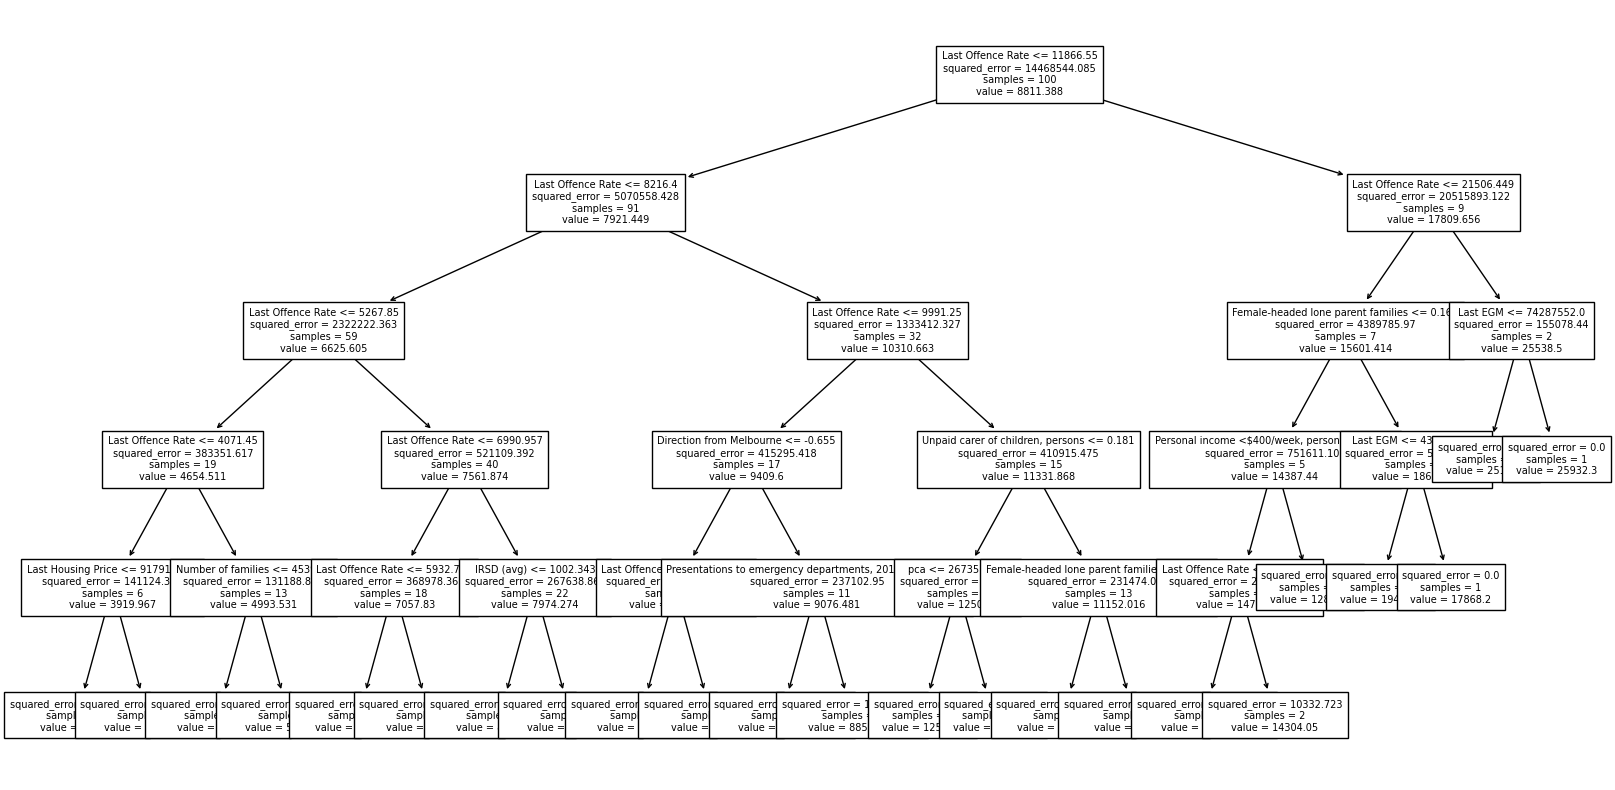

|--- Last Offence Rate <= 11866.55
|   |--- Last Offence Rate <= 8216.40
|   |   |--- Last Offence Rate <= 5267.85
|   |   |   |--- Last Offence Rate <= 4071.45
|   |   |   |   |--- Last Housing Price <= 917912.16
|   |   |   |   |   |--- value: [3571.90]
|   |   |   |   |--- Last Housing Price >  917912.16
|   |   |   |   |   |--- value: [4268.03]
|   |   |   |--- Last Offence Rate >  4071.45
|   |   |   |   |--- Number of families <= 45390.00
|   |   |   |   |   |--- value: [4867.79]
|   |   |   |   |--- Number of families >  45390.00
|   |   |   |   |   |--- value: [5412.67]
|   |   |--- Last Offence Rate >  5267.85
|   |   |   |--- Last Offence Rate <= 6990.96
|   |   |   |   |--- Last Offence Rate <= 5932.78
|   |   |   |   |   |--- value: [6287.98]
|   |   |   |   |--- Last Offence Rate >  5932.78
|   |   |   |   |   |--- value: [7277.79]
|   |   |   |--- Last Offence Rate >  6990.96
|   |   |   |   |--- IRSD (avg) <= 1002.34
|   |   |   |   |   |--- value: [8254.54]
|   |   |   

In [110]:
# Use hold out for now, to investigate the tree closely
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Tuning:
# To reduce validation-time, the models with 1-2 parameters are manually tune using validation set
# Regressor: 3 - 7, by 1 => Best at 5
# AdaBoost: Use regressor best depth + 100 - 400, by 100, for estimators: Best at 300
# RF: Use regressor best depth + 100-400, by 100 for n_estimators: Best at 200
# gradBoost: 
# Use regressor best depth + with GridSearchCV to fine-tune the list of possible hyper-parameters
# Use squared error since it's regression. Log-loss is for logistic regression (probability output for classification)
# Exponential is adaboost (by documentation)
DEPTH = 5

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=200, max_depth=DEPTH),
    "gradBoost": GridSearchCV(GradientBoostingRegressor(
        max_depth = DEPTH,
        loss = "squared_error"), 
        param_grid={
            'n_estimators': [200, 300, 400],
            'min_samples_split': [3, 6],
            'learning_rate': [0.01, 0.1]
        }),
    "linear": LinearRegression(),
    "null": NullModel()
}

# 19 random state yields some odd precision, likely due to how the split is constructed
X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.1, random_state=100)

featureEngineerFunc = getPCA
X_train, X_test, mses, predicts = trainTestPipeline(X_train, X_test, y_train, y_test, featureEngineerFunc, models)

# Reserve the X_test, y_test here as validation set
# Use this block for hyper-param tuning, thus can't use the validation set 
# for testing. Re-use it for training.
X_val = X_test
y_val = y_test

X = X_train
y = y_train

# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(20,10))
plot_tree(models["regressor"], 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=7)
plt.show()

# Use text
tree_rules = export_text(models["regressor"], feature_names=list(X_train))
print(tree_rules)

print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())


MSE of null2 : 705032.6965305188
RMSE of null2 : 839.6535635467866
MSE of regressor : 559506.5591545308
RMSE of regressor : 747.9458193267315
MSE of ada : 502651.7557937404
RMSE of ada : 708.2395230368537
MSE of rf : 881331.2786393261
RMSE of rf : 933.3019937984664
MSE of gradBoost : 636859.7291981801
RMSE of gradBoost : 797.3607849292337
MSE of linear : 532557.3712781157
RMSE of linear : 724.3404949717233
MSE of null : 10685449.603698723
RMSE of null : 3266.3092988544367
Used attributes for regressor tree: 
Last Offence Rate                                       214
Last Housing Price                                       32
Last EGM                                                 30
Allied Health                                            20
pca                                                      16
IRSD (avg)                                               14
TAFE students                                            10
Other Schools                                             8
Primar

<Figure size 640x480 with 0 Axes>

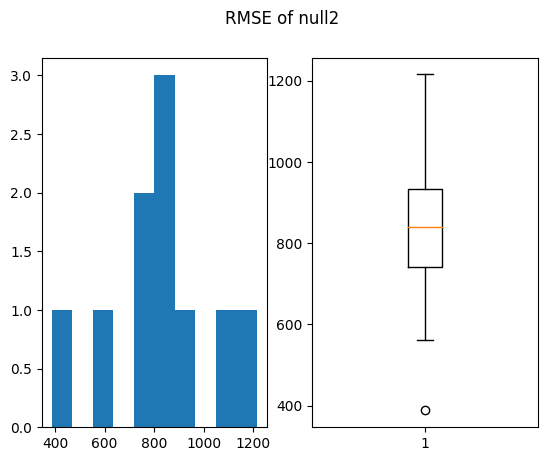

<Figure size 640x480 with 0 Axes>

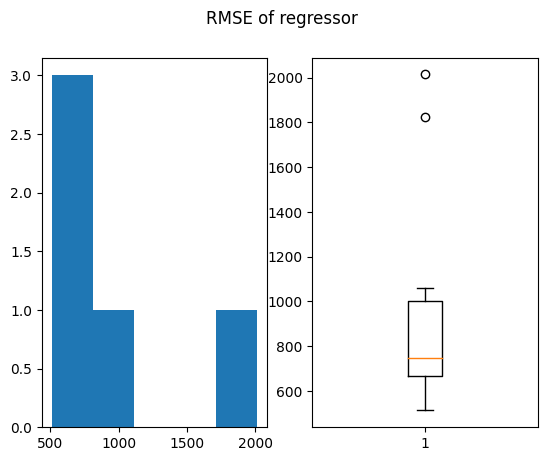

<Figure size 640x480 with 0 Axes>

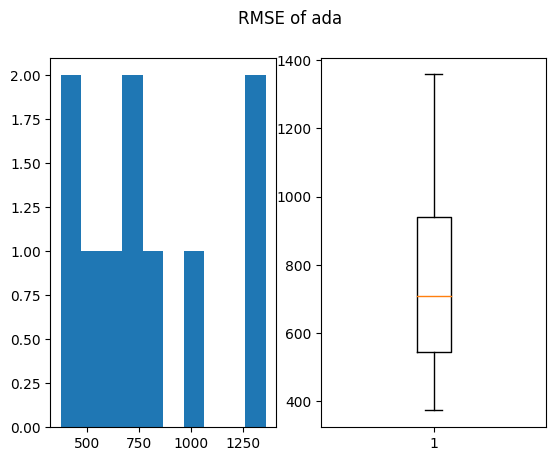

<Figure size 640x480 with 0 Axes>

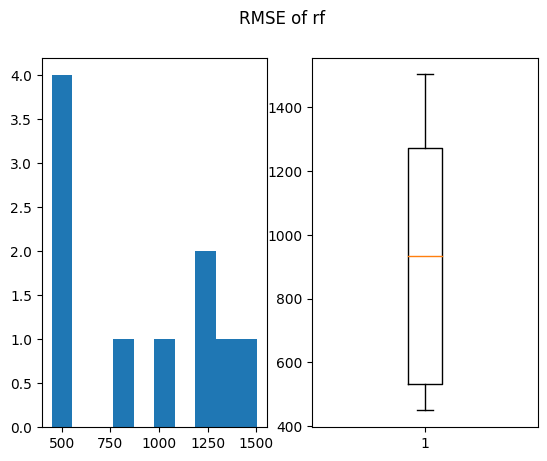

<Figure size 640x480 with 0 Axes>

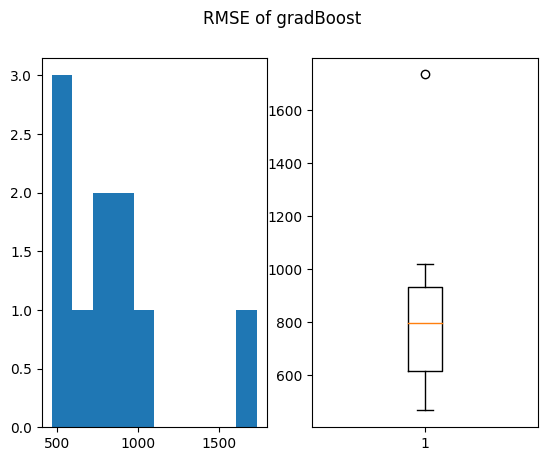

<Figure size 640x480 with 0 Axes>

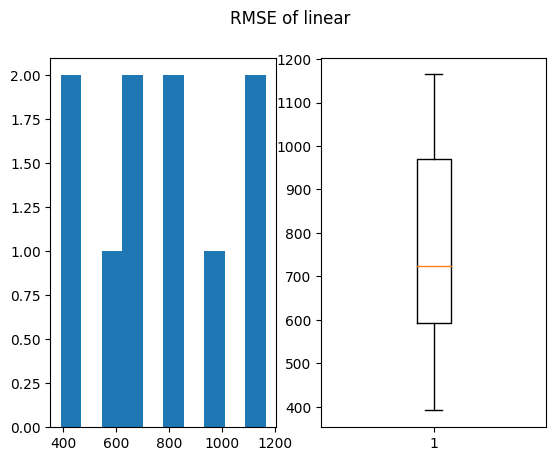

<Figure size 640x480 with 0 Axes>

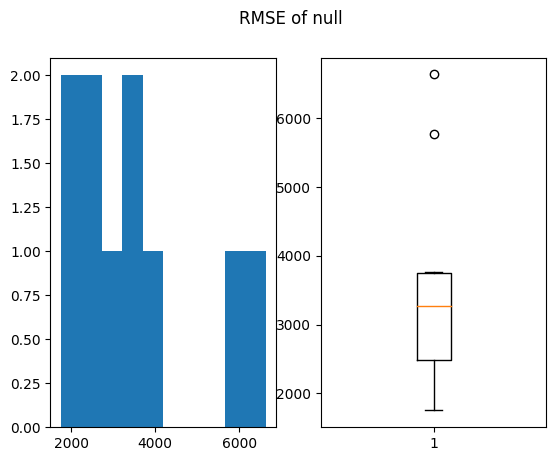

In [101]:
# FEATURE 1:
featureEngineerFunc = None
# featureEngineerFunc = getPCA
KFoldPipeline(X, y, featureEngineerFunc, models, 10, True, X_val=X_val, y_val=y_val)

C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

MSE of null2 : 705032.6965305188
RMSE of null2 : 839.6535635467866
MSE of regressor : 559506.5591545308
RMSE of regressor : 747.9458193267315
MSE of ada : 502651.7557937404
RMSE of ada : 708.2395230368537
MSE of rf : 940764.7849560222
RMSE of rf : 953.2881746058526
MSE of gradBoost : 567602.33033975
RMSE of gradBoost : 752.3502311488826
MSE of linear : 532557.3699133634
RMSE of linear : 724.3404939555005
MSE of null : 10685449.603698723
RMSE of null : 3266.3092988544367
Used attributes for regressor tree: 
Last Offence Rate                                       214
Last Housing Price                                       32
Last EGM                                                 30
Allied Health                                            20
pca                                                      16
IRSD (avg)                                               14
TAFE students                                            10
Other Schools                                             8
Primary 

<Figure size 640x480 with 0 Axes>

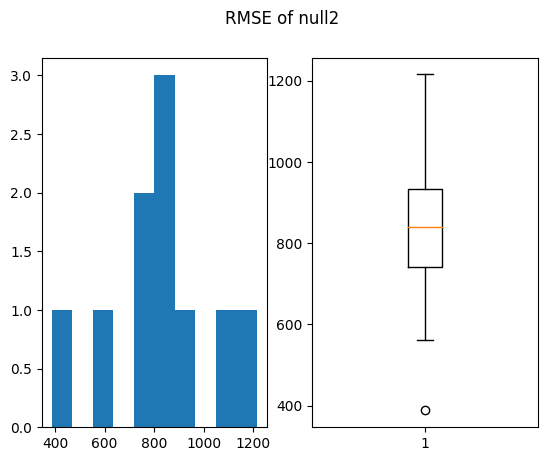

<Figure size 640x480 with 0 Axes>

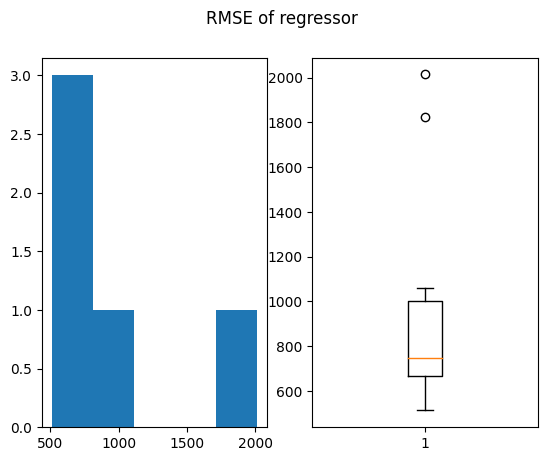

<Figure size 640x480 with 0 Axes>

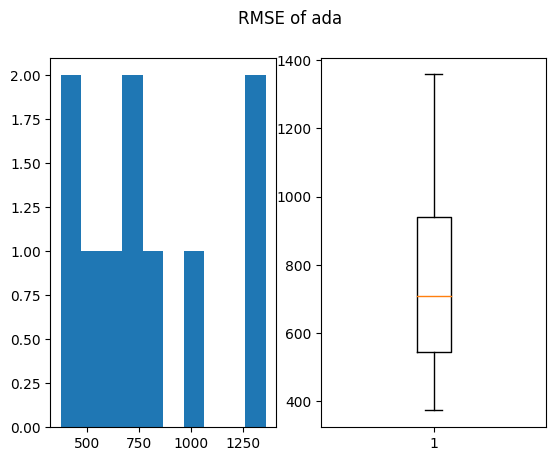

<Figure size 640x480 with 0 Axes>

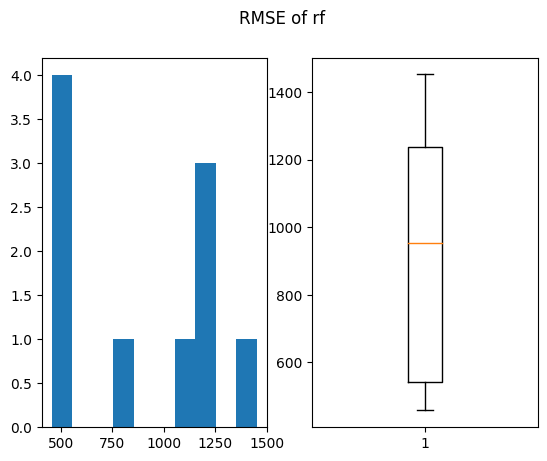

<Figure size 640x480 with 0 Axes>

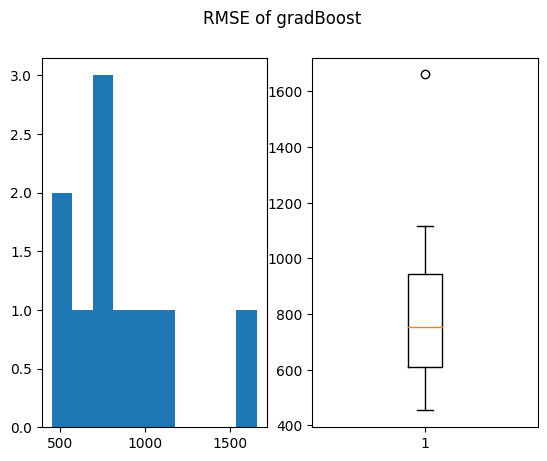

<Figure size 640x480 with 0 Axes>

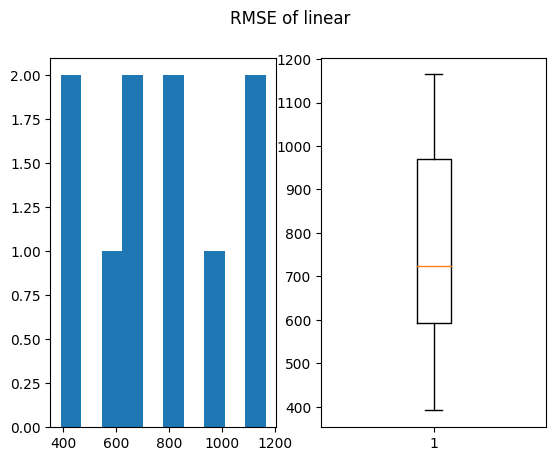

<Figure size 640x480 with 0 Axes>

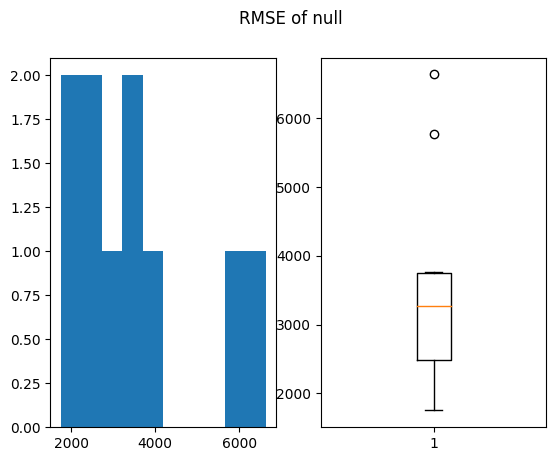

In [102]:
# FEATURE 3:
featureEngineerFunc = getPCA
KFoldPipeline(X, y, featureEngineerFunc, models, 10, True, X_val=X_val, y_val=y_val)

FEATURE 4 (and 2): Pick the top 20 highest NMI score features only + PCA

Remove the getPCA to achieve the feature 2 (no PCA).

In [103]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Since most attribute uses the default discretiser, 
# this function will help with the NMI calculation
def getNMI(att1: np.array, att2: np.array, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    # Avoid the removal of bin by normalizing the data
    norm_att1 = (att1 - att1.min())/ (att1.max() - att1.min()) * 100
    norm_att2 = (att2 - att2.min())/ (att2.max() - att2.min()) * 100

    discrete_att1 = discretizer.fit_transform(norm_att1.reshape(-1, 1)).astype(int)
    discrete_att2 = discretizer.fit_transform(norm_att2.reshape(-1, 1)).astype(int)
    return normalized_mutual_info_score(discrete_att1.flatten(), discrete_att2.flatten())

def getTopNMICommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = getNMI(np.array(X_train[column]), np.array(y_train))
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

def featureEngineerFunc2(X_train, X_test, y_train):
    top20Communities = getTopNMICommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)
    return X_train, X_test

def featureEngineerFunc4(X_train, X_test, y_train):
    X_train, X_test = getPCA(X_train, X_test)
    return featureEngineerFunc2(X_train, X_test, y_train)

d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose widt

MSE of null2 : 705032.6965305188
RMSE of null2 : 839.6535635467866
MSE of regressor : 649801.542147184
RMSE of regressor : 805.9595559645063
MSE of ada : 491059.2983536456
RMSE of ada : 698.7965039554991
MSE of rf : 1046408.4399697752
RMSE of rf : 1005.8985737145656
MSE of gradBoost : 581999.932619949
RMSE of gradBoost : 761.9088442587372
MSE of linear : 693038.8202072368
RMSE of linear : 832.272625063553
MSE of null : 10685449.603698723
RMSE of null : 3266.3092988544367
Used attributes for regressor tree: 
Last Offence Rate                                    222
Last Housing Price                                    44
Last EGM                                              26
pca                                                   24
IRSD (avg)                                            22
Presentations to emergency departments, 2012-13       22
Female-headed lone parent families                    18
IRSD (min)                                            12
Dwellings with no internet     

<Figure size 640x480 with 0 Axes>

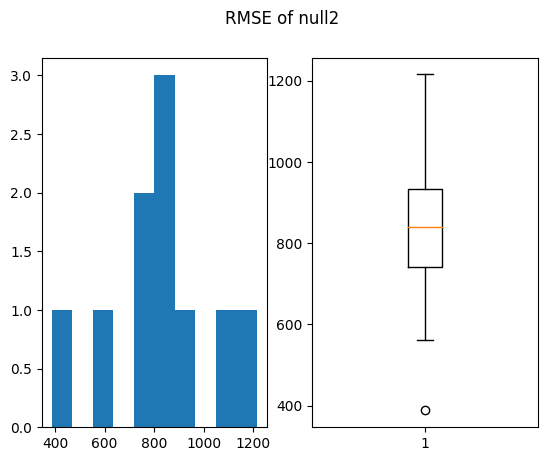

<Figure size 640x480 with 0 Axes>

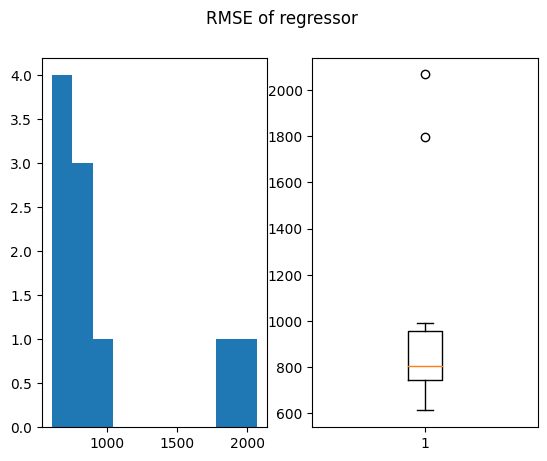

<Figure size 640x480 with 0 Axes>

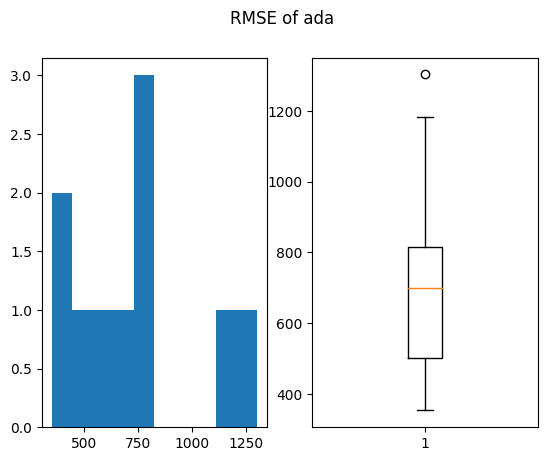

<Figure size 640x480 with 0 Axes>

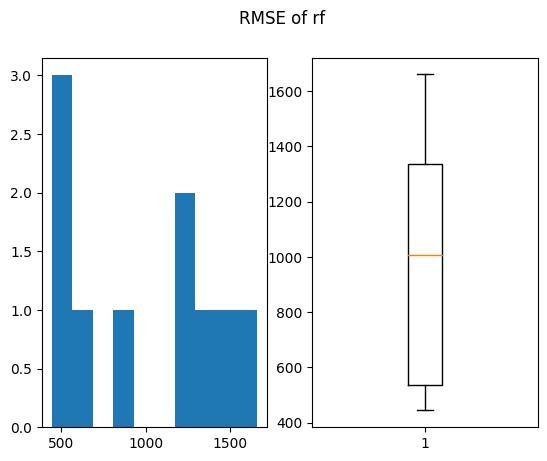

<Figure size 640x480 with 0 Axes>

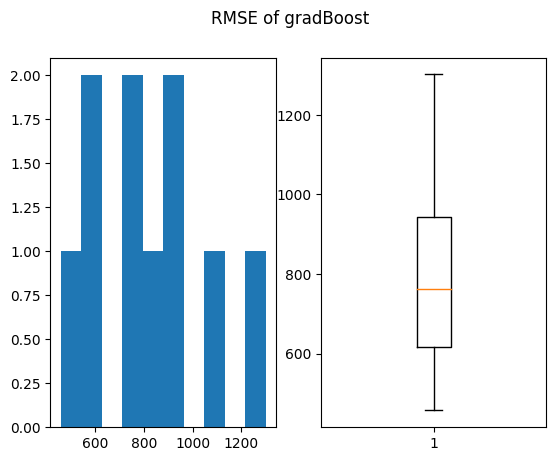

<Figure size 640x480 with 0 Axes>

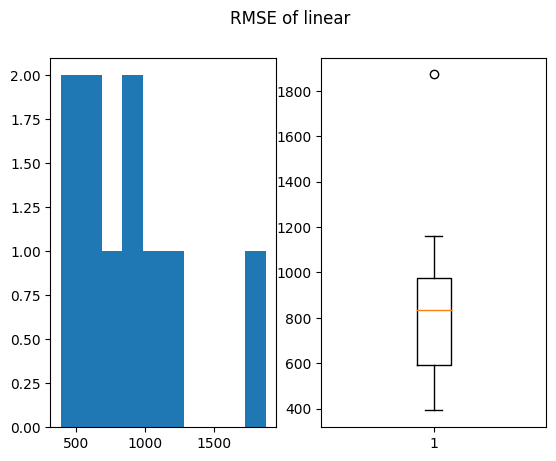

<Figure size 640x480 with 0 Axes>

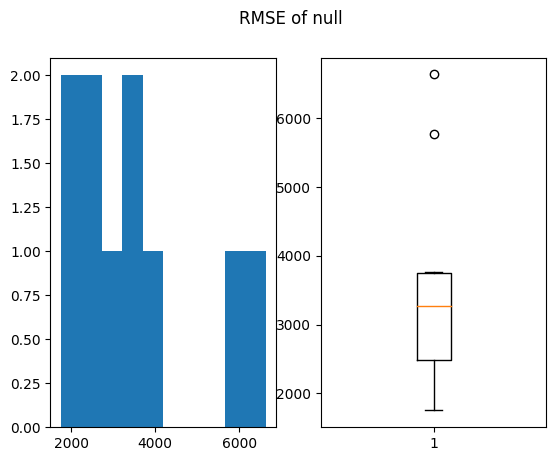

In [111]:
# Feature 2
KFoldPipeline(X, y, featureEngineerFunc2, models, 10, True, X_val=X_val, y_val=y_val)

C:\Users\DELL\AppData\Local\Temp\ipykernel_9512\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0

MSE of null2 : 705032.6965305188
RMSE of null2 : 839.6535635467866
MSE of regressor : 649801.542147184
RMSE of regressor : 805.9595559645063
MSE of ada : 491059.2983536456
RMSE of ada : 698.7965039554991
MSE of rf : 984777.9611929457
RMSE of rf : 972.6744379074321
MSE of gradBoost : 651088.3577749245
RMSE of gradBoost : 805.9326858234766
MSE of linear : 692946.3402838635
RMSE of linear : 832.2157628601288
MSE of null : 10685449.603698723
RMSE of null : 3266.3092988544367
Used attributes for regressor tree: 
Last Offence Rate                                    222
Last Housing Price                                    44
Last EGM                                              26
pca                                                   24
IRSD (avg)                                            22
Presentations to emergency departments, 2012-13       22
Female-headed lone parent families                    18
IRSD (min)                                            12
Dwellings with no internet     

<Figure size 640x480 with 0 Axes>

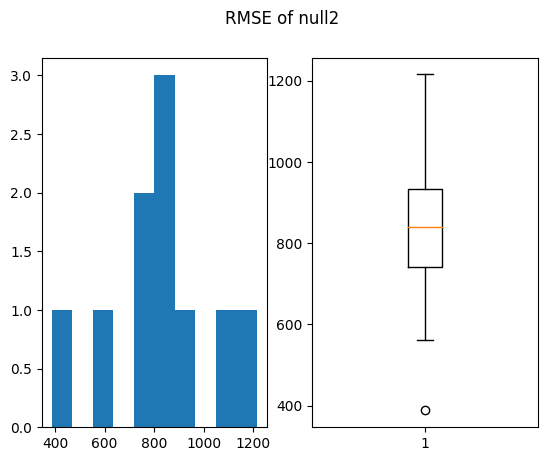

<Figure size 640x480 with 0 Axes>

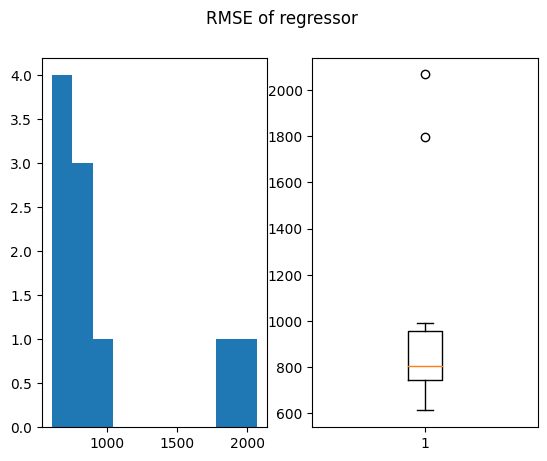

<Figure size 640x480 with 0 Axes>

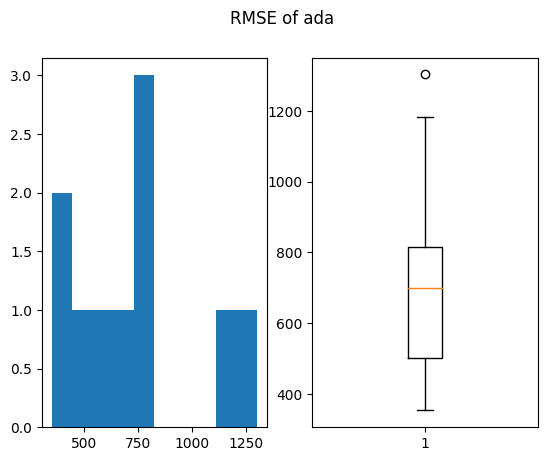

<Figure size 640x480 with 0 Axes>

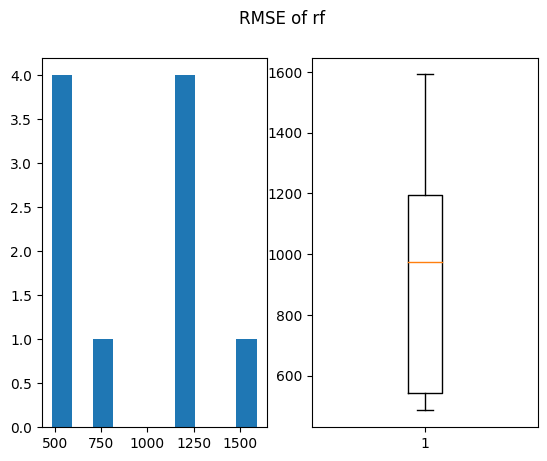

<Figure size 640x480 with 0 Axes>

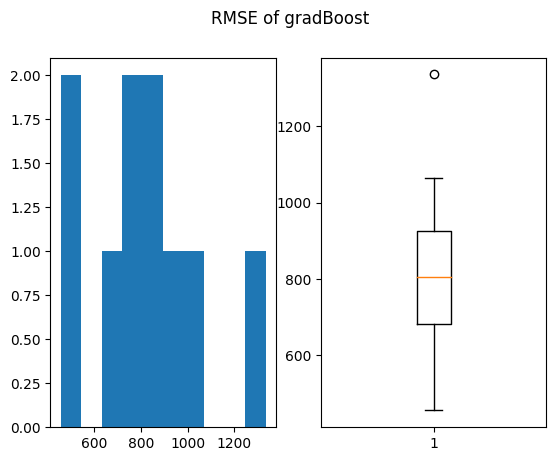

<Figure size 640x480 with 0 Axes>

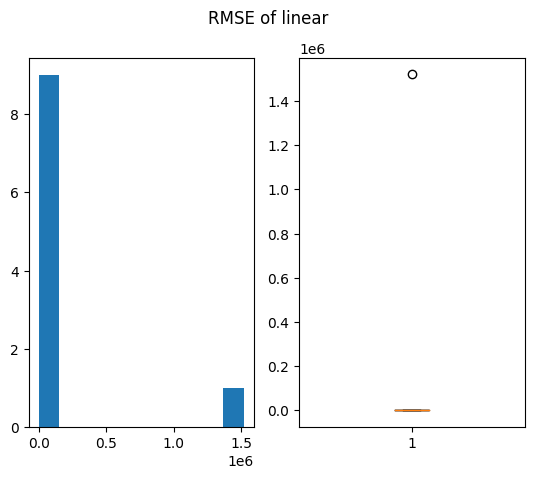

<Figure size 640x480 with 0 Axes>

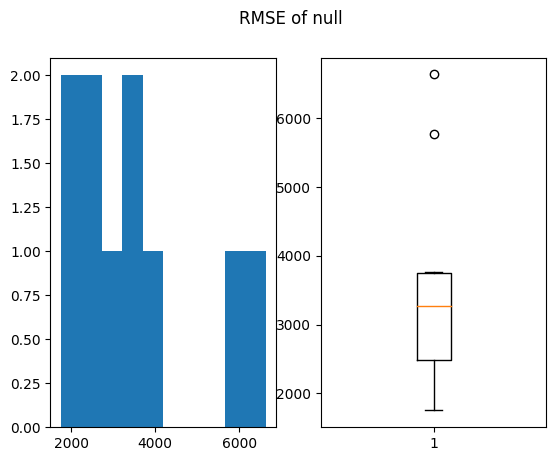

In [112]:
# Feature 4
KFoldPipeline(X, y, featureEngineerFunc4, models, 10, True, X_val=X_val, y_val=y_val)

In [106]:
# Try restricting to top 20 of highest correlation coeff for Linear model
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def getTopCorrCoeffCommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = abs(np.corrcoef(np.array(X_train[column]), np.array(y_train))[0][1])
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

def featureEngineerLinearFunc2(X_train, X_test, y_train):
    # X_train, X_test = getPCA(X_train, X_test)

    top20Communities = getTopCorrCoeffCommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)
    return X_train, X_test

MSE of null2 : 428205.588030917
RMSE of null2 : 654.3662763885982
MSE of linear : 366494.0086036296
RMSE of linear : 605.0362424446548
MSE of null : 6793443.447732713
RMSE of null : 2606.3806385903026
Used attributes for regressor tree: 
Series([], Name: count, dtype: int64)


<Figure size 640x480 with 0 Axes>

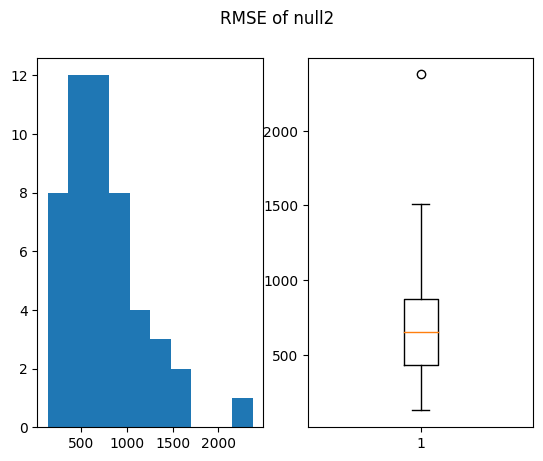

<Figure size 640x480 with 0 Axes>

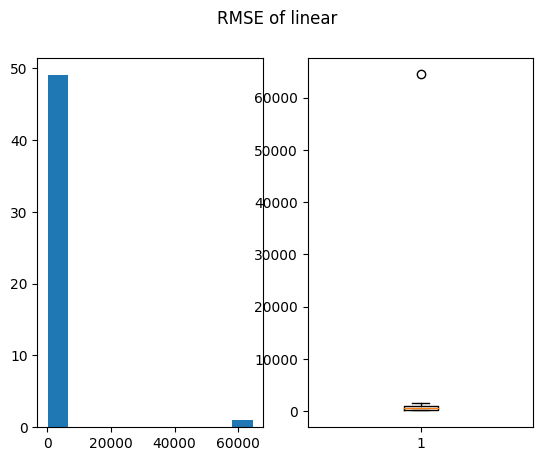

<Figure size 640x480 with 0 Axes>

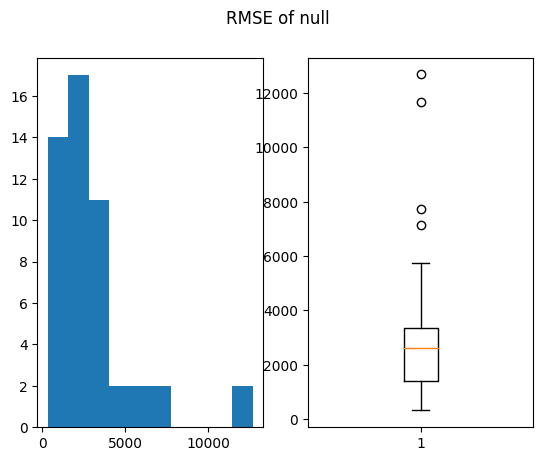

In [107]:
models = {
    "linear": LinearRegression(),
    "null": NullModel()
}

KFoldPipeline(X, y, featureEngineerLinearFunc2, models, 50, True, X_val=X_val, y_val=y_val)